# AutoDecoders on the ModelNet 10 data

### Change directory to kaolin

The kaolin library must be downloaded from <https://github.com/NVIDIAGameWorks/kaolin> and installed with instructions from their README

### Note: The setenv.sh script must be run to set up proper kaolin paths

In [1]:
# import necessary libraries
import kaolin as kal
from kaolin.datasets import modelnet
from torchvision import transforms

import torch
import numpy as np
from pathlib import Path

from utils import visualize_npy

%matplotlib inline

   No module named 'nuscenes'
   None


Traceback (most recent call last):
  File "/home/mmvc/.conda/envs/sms1198_env/lib/python3.7/site-packages/kaolin-0.1.0-py3.7-linux-x86_64.egg/kaolin/datasets/__init__.py", line 11, in <module>
    from .nusc import NuscDetection
  File "/home/mmvc/.conda/envs/sms1198_env/lib/python3.7/site-packages/kaolin-0.1.0-py3.7-linux-x86_64.egg/kaolin/datasets/nusc.py", line 21, in <module>
    from nuscenes.utils.geometry_utils import transform_matrix
ModuleNotFoundError: No module named 'nuscenes'


## Kaolin mesh to point cloud conversion functions

In [2]:
def convert_mesh_to_pt_cloud(mesh, num_points=5000):
    return kal.conversions.trianglemesh_to_pointcloud(mesh, num_points)[0]

In [3]:
modelnet10_category_list = [
    "bathtub",
    "bed",
    "chair",
    "desk",
    "dresser",
    "monitor",
    "night_stand",
    "sofa",
    "table",
    "toilet",
]

modelnet40_category_list = [
    "airplane",
    "bench",
    "bowl",
    "cone",
    "desk",
    "flower_pot",
    "keyboard",
    "mantel",
    "person",
    "radio",
    "sofa",
    "table",
    "tv_stand",
    "xbox",
    "bathtub",
    "bookshelf",
    "car",
    "cup",
    "door",
    "glass_box",
    "lamp",
    "monitor",
    "piano",
    "range_hood",
    "stairs",
    "tent",
    "vase",
    "bed",
    "bottle",
    "chair",
    "curtain",
    "dresser",
    "guitar",
    "laptop",
    "night_stand",
    "plant",
    "sink",
    "stool",
    "toilet",
    "wardrobe",
]

### Loads the `.off` files from ModelNet as torch.Tensors and saves them as `.npy` files for faster loading

In [9]:
def unload_off_to_npy(
    category_list,
    split="train",
    src_dir="./data/ModelNet10/",
    dump_npy_dir="./data/ModelNet10_train_npy/",
):
    for category in category_list:
        dump_npy_file = "modelnet_" + category + ".npy"
        npy_dump_file = Path(dump_npy_dir + dump_npy_file)
        if npy_dump_file.is_file():
            print(f"{dump_npy_dir + dump_npy_file} already exists. Skipping now")
            continue

        print(f"Unloading {category} to npy")
        mdnet = modelnet.ModelNet(
            root=src_dir,
            categories=[category],
            split=split,
            transform=transforms.Compose([convert_mesh_to_pt_cloud]),
        )
        print(len(mdnet))
        # data_loader = DataLoader(mdnet, batch_size=1,
        #                         shuffle=True, num_workers=0)
        X = None
        # Load the entire .off files into one Tensor object X one at a time
        for i in range(len(mdnet)):
            try:
                if X is None:
                    X = mdnet[i][0].unsqueeze(0)
                else:
                    X = torch.cat([X, mdnet[i][0].unsqueeze(0)], dim=0)
            except Exception as e:
                print(e)
                print(f"Skipped {i}")
            if i % 20:
                if X is not None:
                    print(X.shape)

        dump_npy_file = "modelnet_" + category + ".npy"
        if X is not None:
            np.save(dump_npy_dir + dump_npy_file, X.numpy())
            print(
                f"Dumped category {category} with shape {X.shape} under {dump_npy_dir} as {dump_npy_file}"
            )
            return
        print("Invalid off file. Count not read any values")

# Unload all .off files into a .npy pickle format

WARNING: Requires a lot of time

The original `.off` ModelNet10 files must be downloaded from <https://modelnet.cs.princeton.edu/>

In [ ]:
# unload ModelNet40 off to npy
unload_off_to_npy(
    modelnet40_category_list,
    split="train",
    src_dir="./data/ModelNet40/",
    dump_npy_dir="./data/ModelNet40_train_npy/",
)
unload_off_to_npy(
    modelnet40_category_list,
    split="test",
    src_dir="./data/ModelNet40/",
    dump_npy_dir="./data/ModelNet40_test_npy/",
)

In [ ]:
# unload ModelNet10 off to npy
unload_off_to_npy(
    modelnet10_category_list,
    split="train",
    src_dir="./data/ModelNet10/",
    dump_npy_dir="./data/ModelNet10_train_npy/",
)
unload_off_to_npy(
    modelnet10_category_list,
    split="test",
    src_dir="./data/ModelNet10/",
    dump_npy_dir="./data/ModelNet10_test_npy/",
)

## Library imports for autodecoder ensemble nets

In [27]:


# Try importing tqdm notebook
try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError as e:
    print("tdqm.notebook not found. Try updating tdqm. Reverting to base tqdm", e)





# CUSTOM IMPORTS

# utility functions
from src.utils import (
    get_X_y_from_npy,
)
from src.utils import (
    visualize_npy,
    HyperParameter,
    DirectorySetting,
)

# models
from src.models import EnsembleCompNet

# datasets
from src.datasets import PointDriftDS, EncodingDS

# train and test modules
from src.trainer import (
    find_encoding,
    train_decoder,
    train_compnet,
    eval_compnet,
)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

tdqm.notebook not found. Try updating tdqm. Reverting to base tqdm No module named 'tqdm.notebook'


-------
## Declaring the required modules and functions

### Setting up CUDA devices

In [3]:
device = None
use_cuda = torch.cuda.is_available()

if use_cuda:
    # inbuilt cudnn auto-tuner searches for best algorithm for hardware
    # cuddn.benchmark should be set to True when our input size does not vary
    torch.backends.cudnn.benchmark = True
    print("GPU training available")
    device = torch.device("cuda:0")
    print(f"Index of CUDA device in use is {torch.cuda.current_device()}")
else:
    print("GPU training NOT available")
    device = torch.device("cpu")
    print("Can only train on CPU")

GPU training available
Index of CUDA device in use is 0


In [4]:
DEBUG = True
SEED = 17 * 19

HP = HyperParameter(
    epochs=10,
    l2_reg=None,
    batch_size=16,
    num_point_cloud=3,
    encoding_iters=1000,
    encoding_size=256,
)
DS = DirectorySetting()

np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed(SEED)

# Load the ModelNet10 data

In [2]:
# Load the X_train, X_test, y_train, y_test after reading from the .npy file in the disk
train = "./data/ModelNet10_train_npy/"
test = "./data/ModelNet10_test_npy/"

# Warning: The train and test directories must have the same number of files
X_train, y_train = get_X_y_from_npy(train, 100)
X_test, y_test = get_X_y_from_npy(test, 100)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

Adding data/ModelNet10_train_npy/modelnet_chair.npy to X. X is now (889, 5000, 3)
Adding data/ModelNet10_train_npy/modelnet_sofa.npy to X. X is now (1569, 5000, 3)
Adding data/ModelNet10_train_npy/modelnet_night_stand.npy to X. X is now (1769, 5000, 3)
Adding data/ModelNet10_train_npy/modelnet_bed.npy to X. X is now (2284, 5000, 3)
Adding data/ModelNet10_train_npy/modelnet_table.npy to X. X is now (2676, 5000, 3)
Adding data/ModelNet10_train_npy/modelnet_toilet.npy to X. X is now (3020, 5000, 3)
Adding data/ModelNet10_train_npy/modelnet_monitor.npy to X. X is now (3485, 5000, 3)
Adding data/ModelNet10_train_npy/modelnet_bathtub.npy to X. X is now (3591, 5000, 3)
Adding data/ModelNet10_train_npy/modelnet_dresser.npy to X. X is now (3791, 5000, 3)
Adding data/ModelNet10_train_npy/modelnet_desk.npy to X. X is now (3991, 5000, 3)
Adding data/ModelNet10_test_npy/modelnet_chair.npy to X. X is now (100, 5000, 3)
Adding data/ModelNet10_test_npy/modelnet_sofa.npy to X. X is now (200, 5000, 3)
A

((3991, 5000, 3), (908, 5000, 3), (3991, 1), (908, 1))

## Testing our AutoDecoder and CompNets with the ModelNet10 data

### Looking at the ModelNet10 data

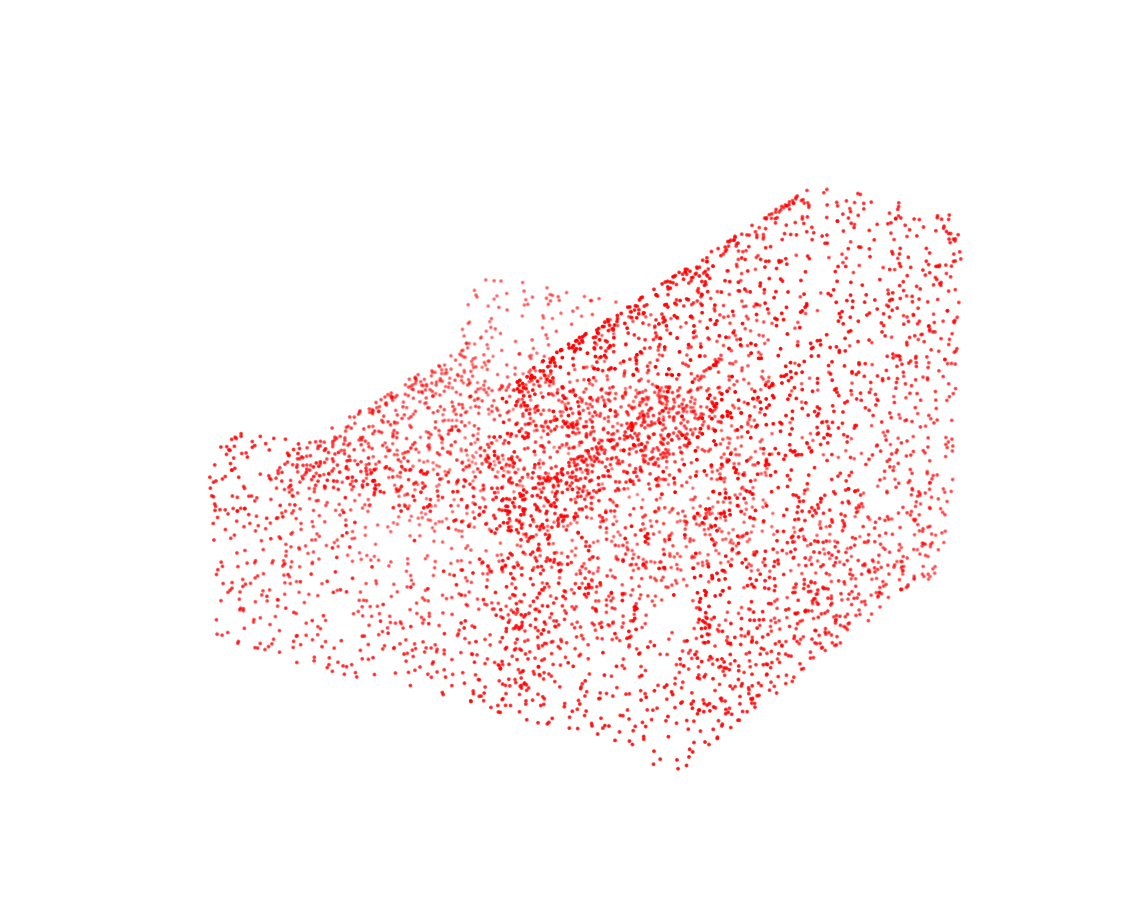

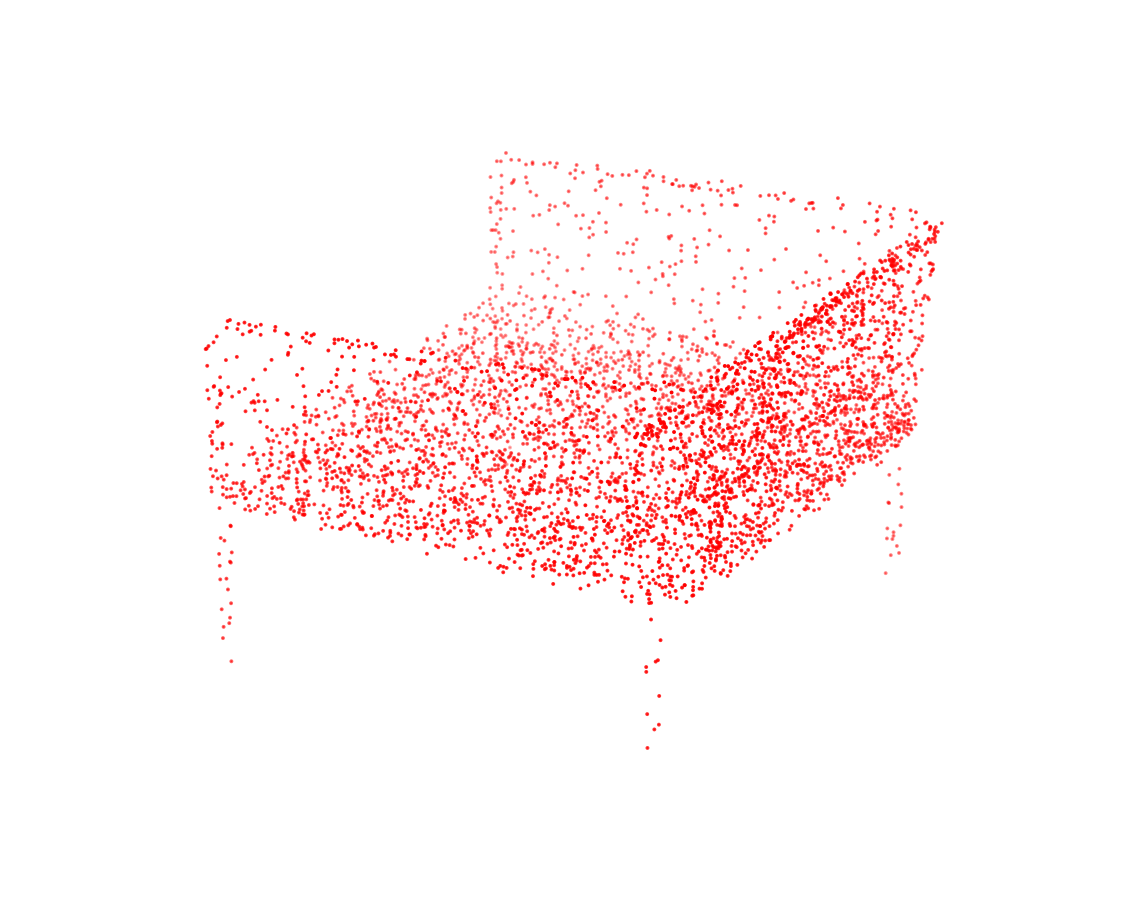

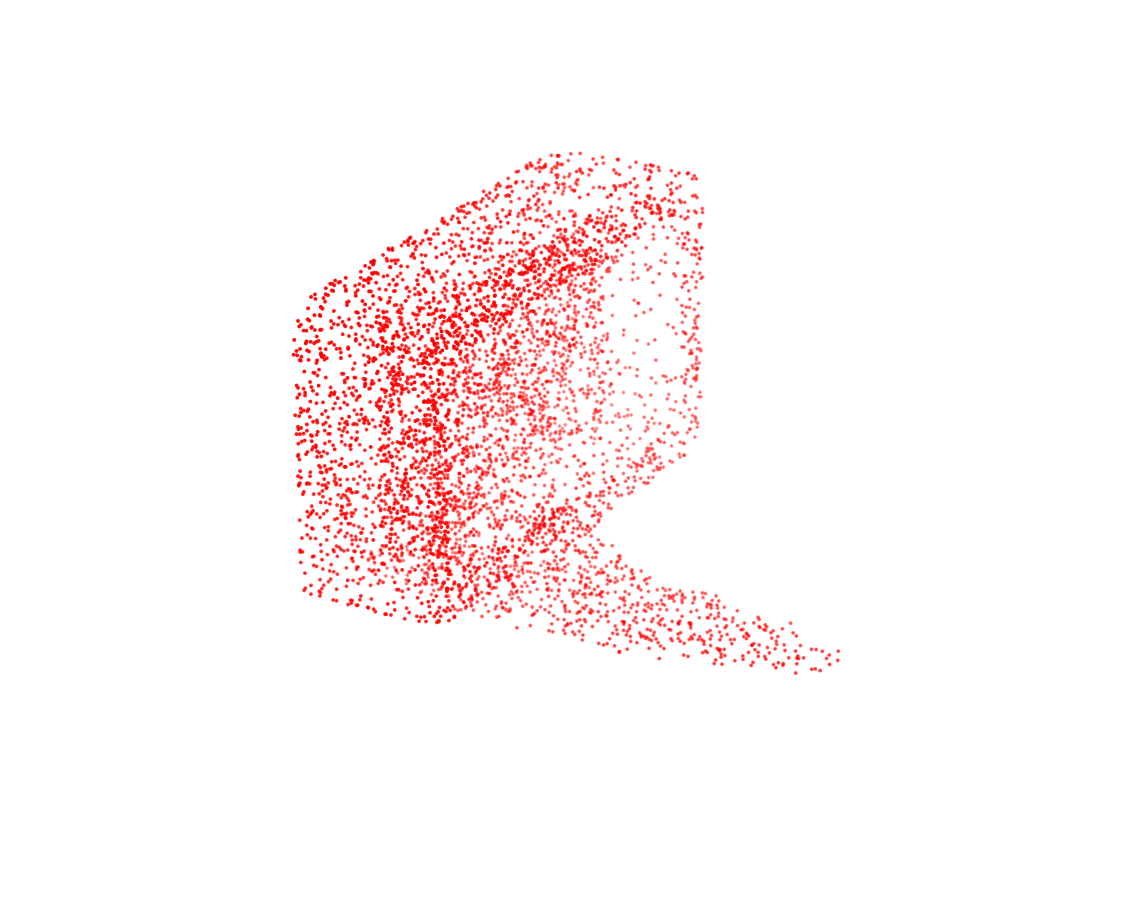

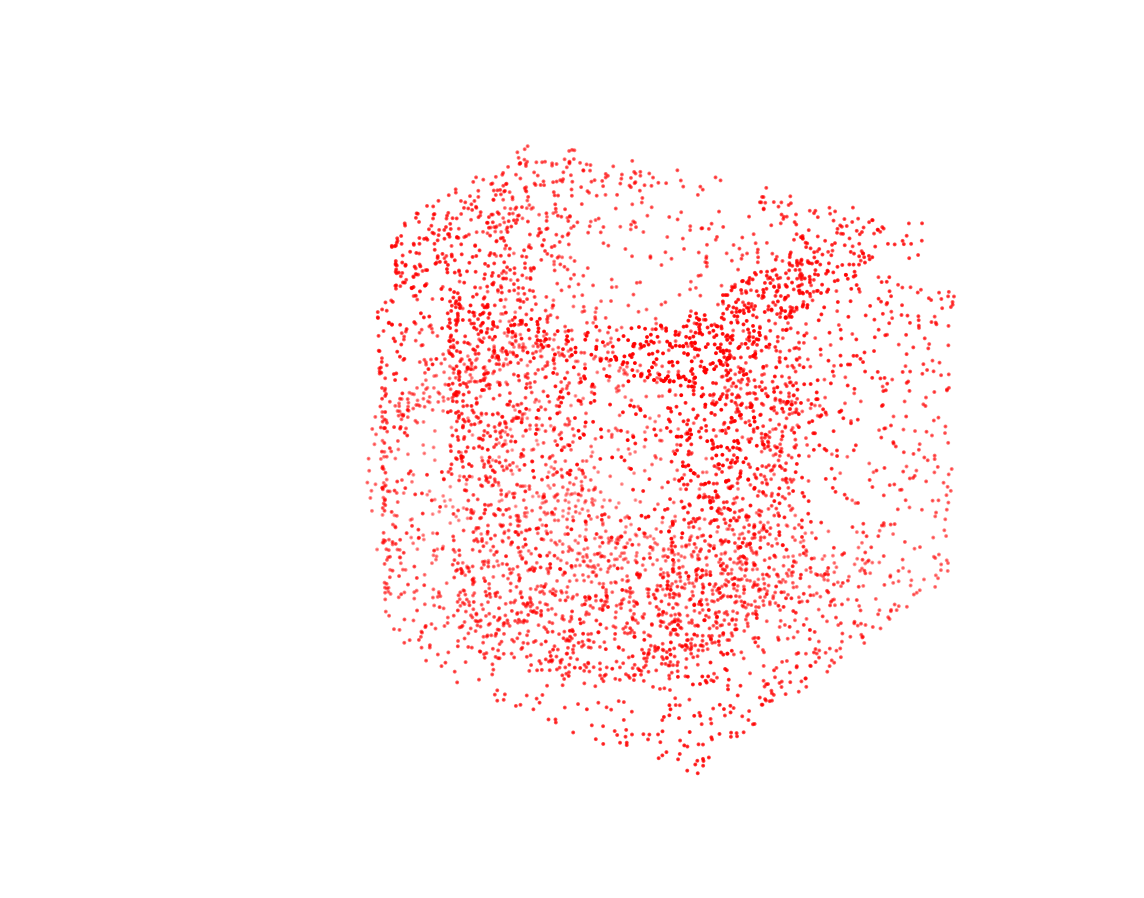

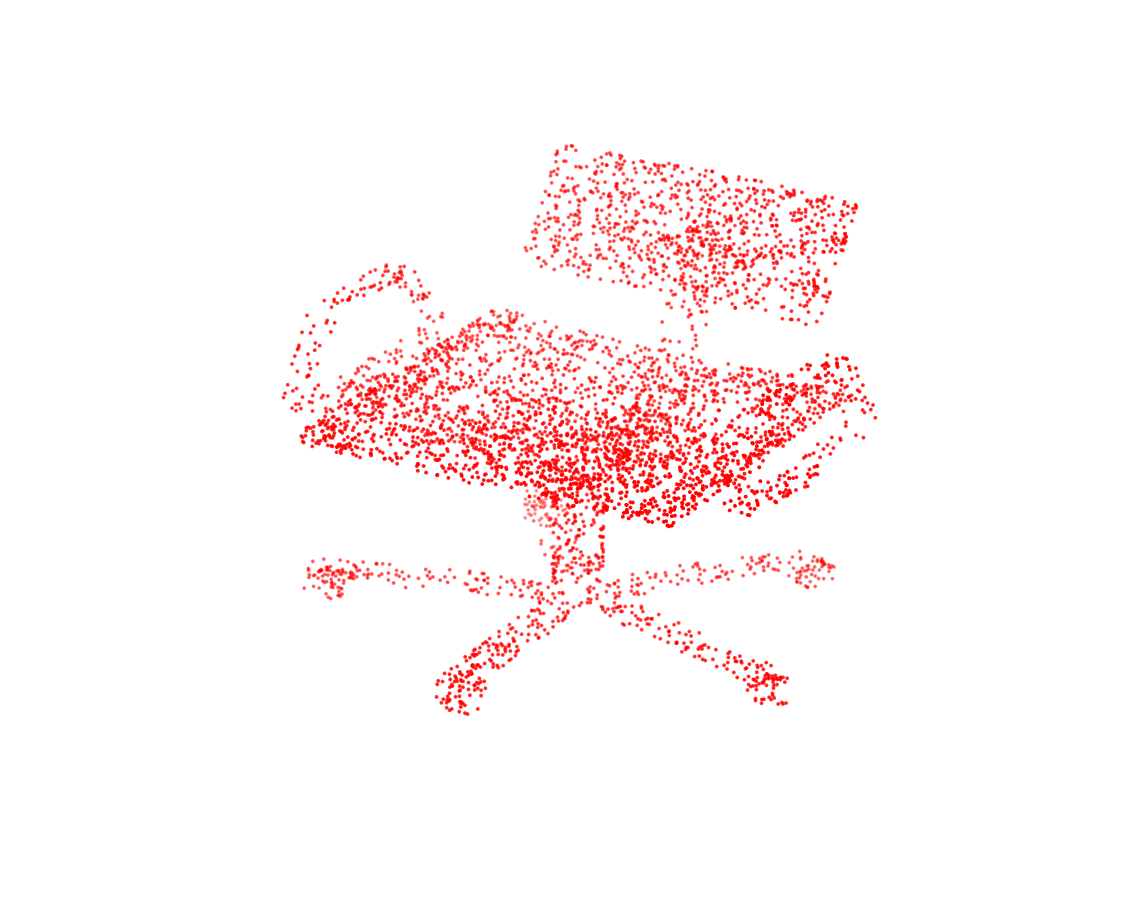

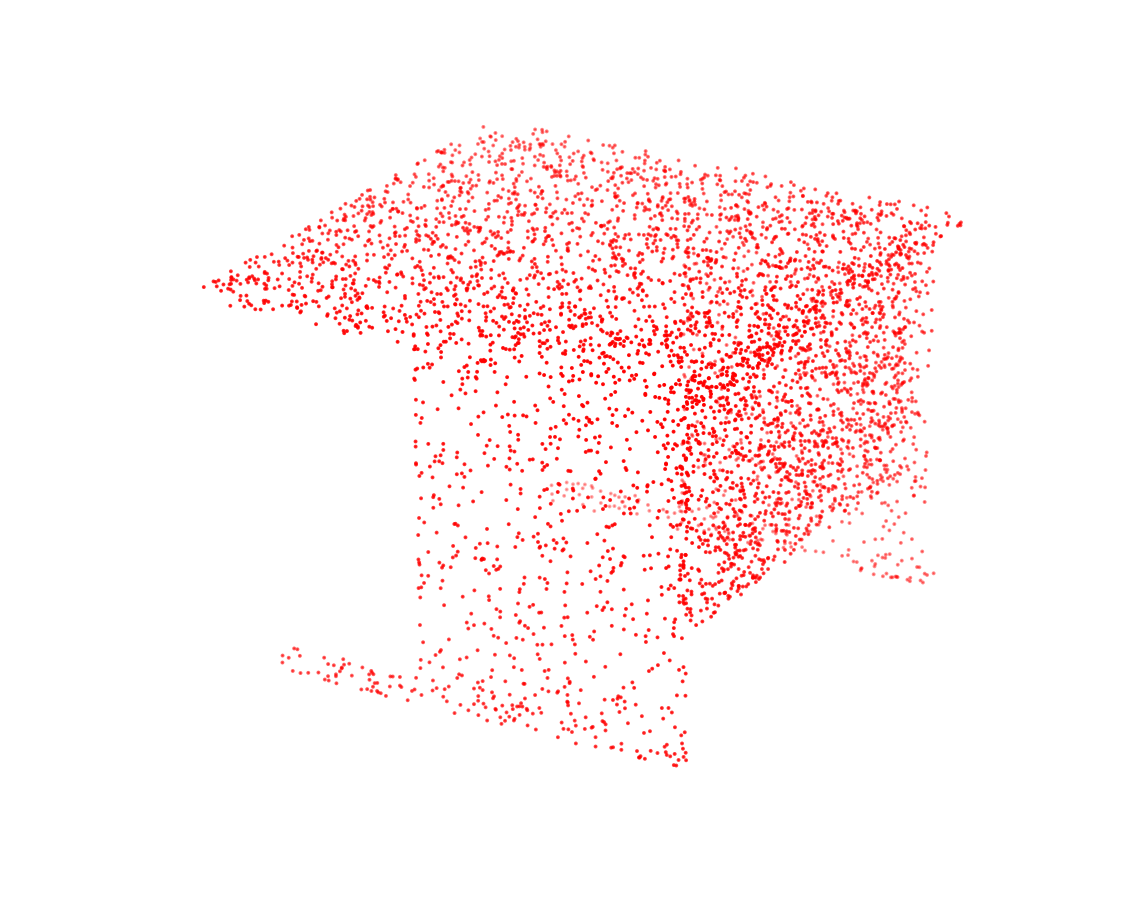

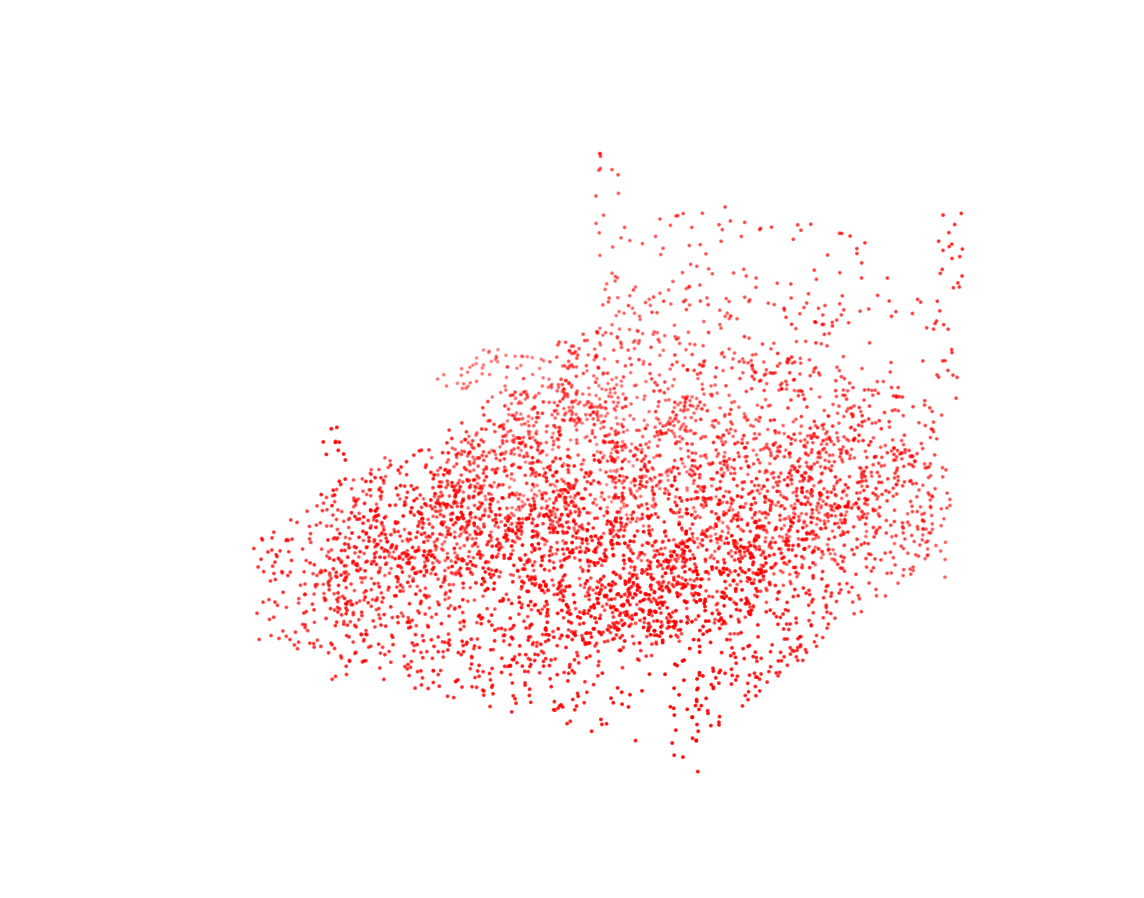

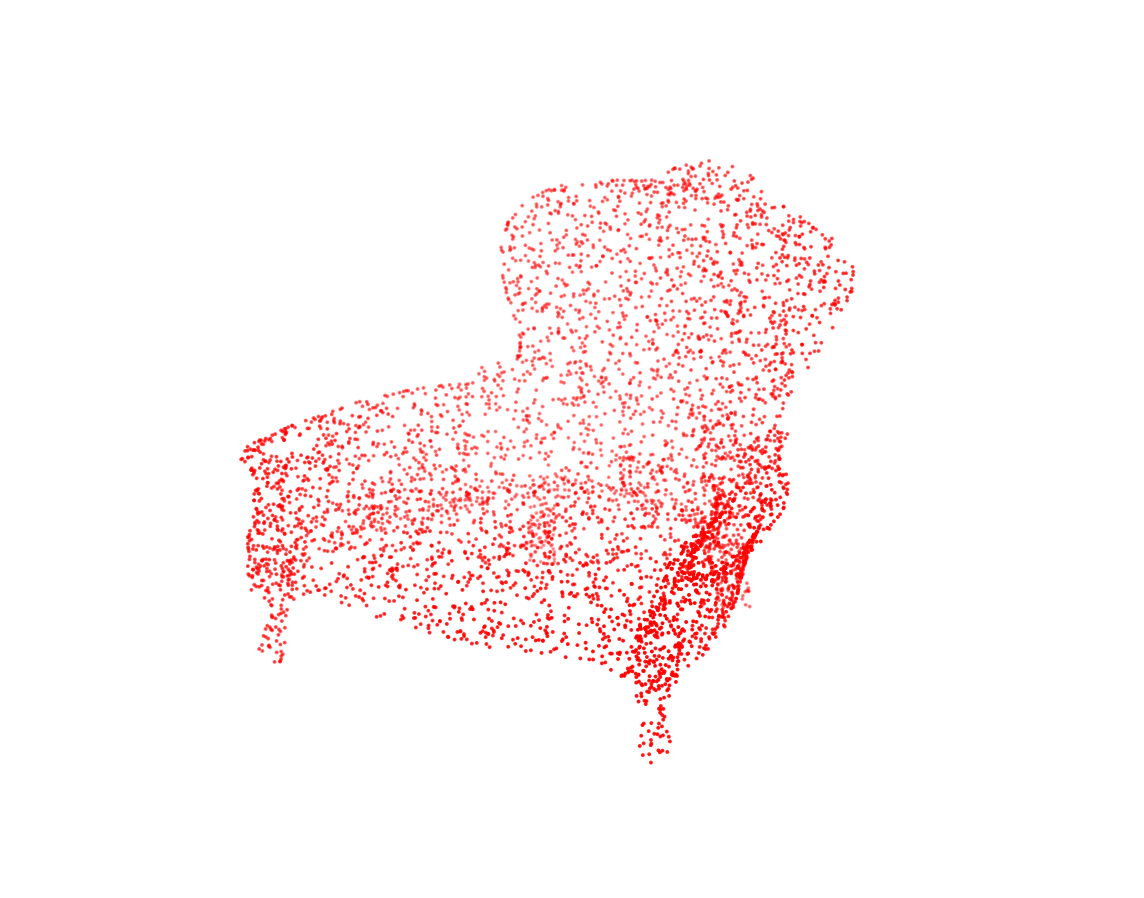

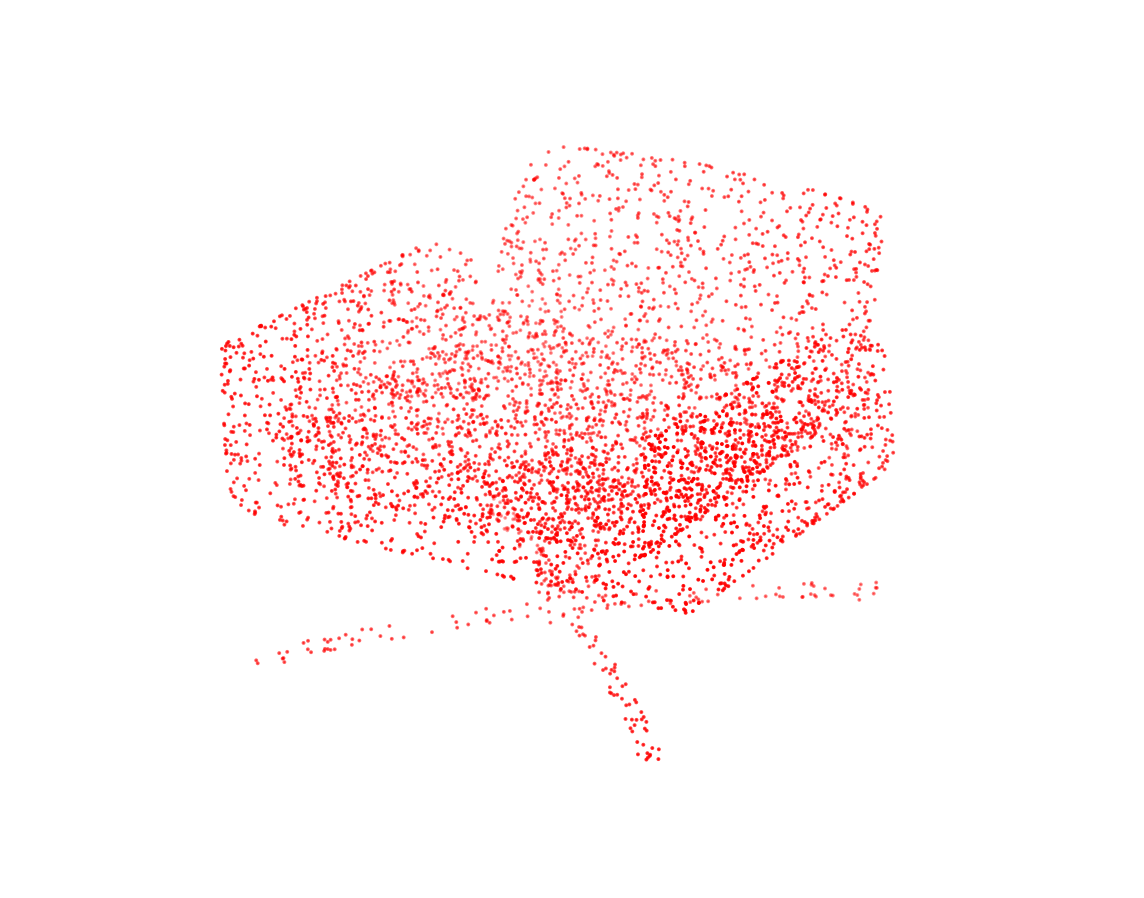

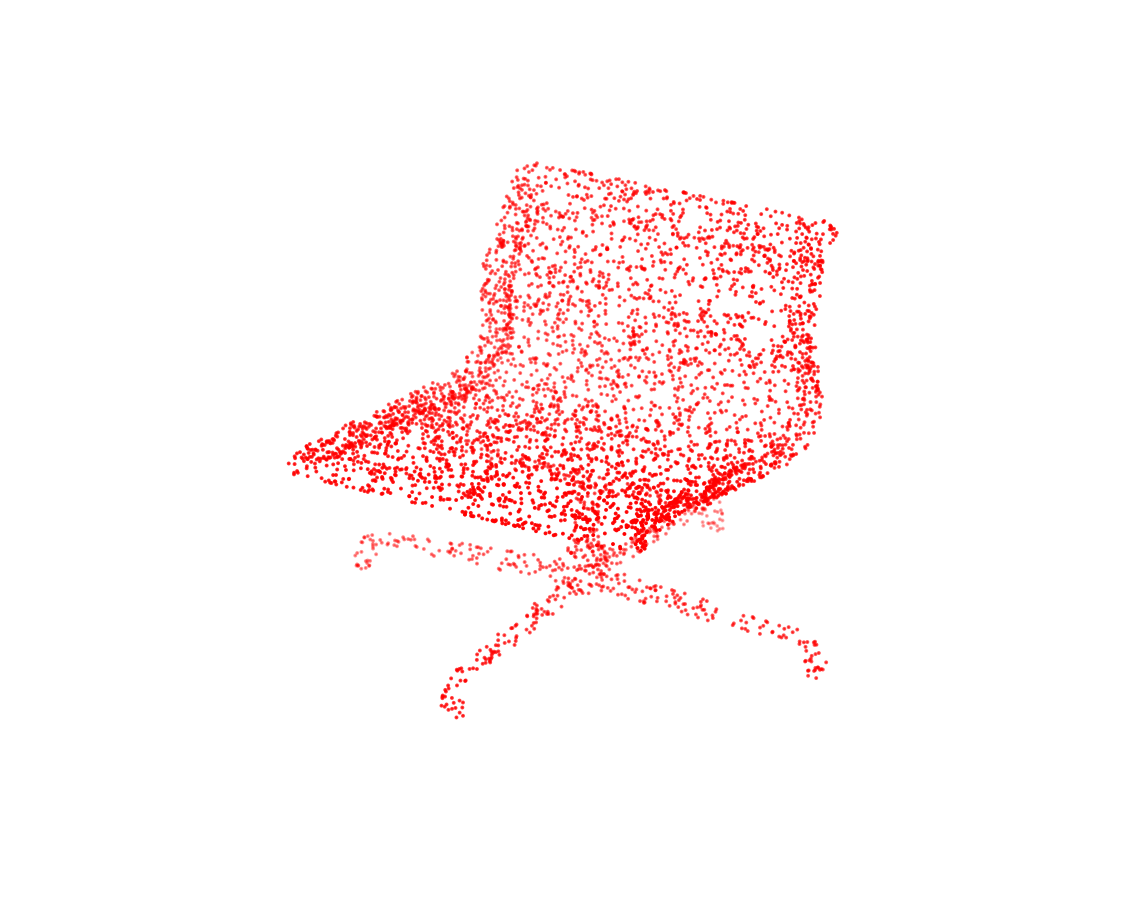

In [5]:
for i in range(10):
    visualize_npy(X_train[i], save_img_fpath=None)

In [ ]:
adnet_HP = HyperParameter(lr=0.001, epochs=4)
train_ds = PointDriftDS(X_train, y_train)
test_ds = PointDriftDS(X_test, y_test)

# train autodecoder
mn_autodecoder = train_decoder(
    adnet_HP, DS, train_ds=train_ds, save_wt_fname="mnet_decoder.pth"
)

In [ ]:
# get the train encodings
train_encoding_ds = EncodingDS(PointDriftDS(X_train, y_train), mn_autodecoder)
train_result = train_encoding_ds.train_encodings(
    find_encoding, num_iterations=15, lr=0.05
)

# get the test encodings
test_encoding_ds = EncodingDS(PointDriftDS(X_test, y_test), mn_autodecoder)
test_result = test_encoding_ds.train_encodings(
    find_encoding, num_iterations=15, lr=0.05
)

In [ ]:
# train the compnet
HP = HyperParameter(epochs=20, batch_size=16, lr=0.001)
mn_compnet = train_compnet(
    HP,
    DS,
    train_ds=train_encoding_ds,
    save_wt_fname="mnet_compnet.pth",
)

### Single CompNet result on ModelNet10 Data

------------------ Evaluation Report ------------------
Total Accuracy: 0.6227973568281938
After 57 batches and 908 test points

Metrics for the same class:
Avg loss: 0.6118765379253187
Precision: 0.6048918156161807
Recall: 0.7081497797356828
F1 Score: 0.6524606798579402

Metrics for the diff class:
Avg loss: 0.6967409943279467
Precision: 0.648074369189907
Recall: 0.5374449339207048
F1 Score: 0.5875978326309451


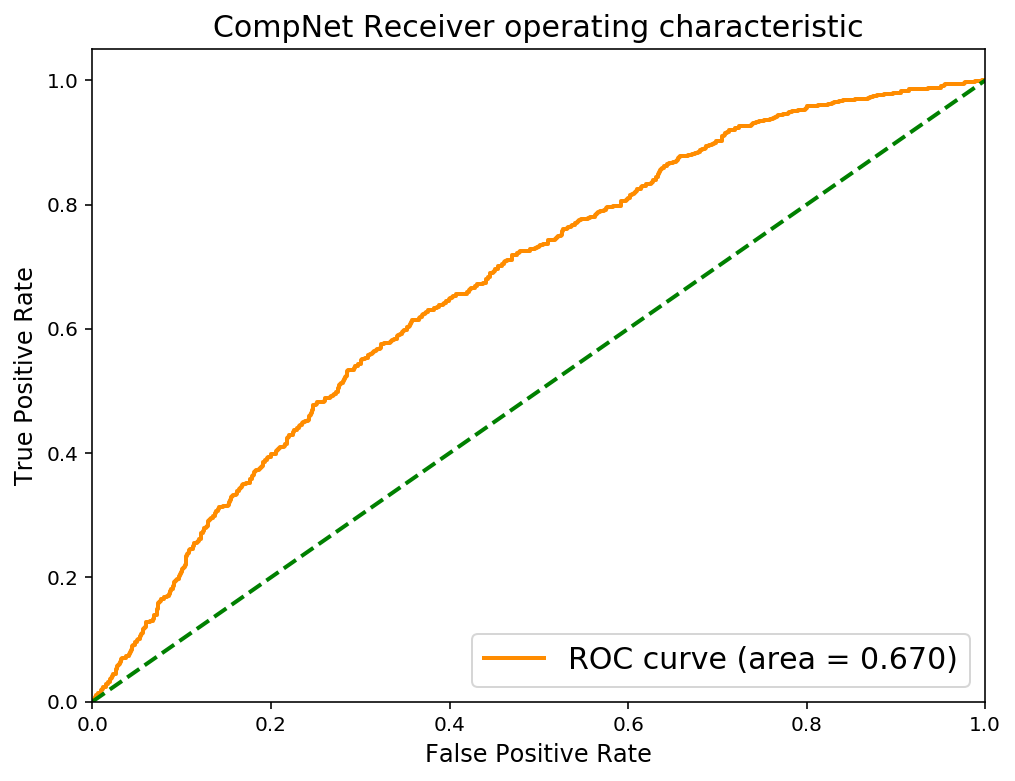

(34.876962661743164, 39.71423667669296, 643.0, 488.0, 265.0, 420.0, 57, 908)

In [35]:
# evaluate compnet
eval_compnet(mn_compnet, test_encoding_ds)

### Train Ensemble CompNet1 on ModelNet10 Data

In [ ]:
ensemble_HP = HyperParameter(epochs=20, batch_size=16, lr=0.001)

# Train with the ensemble net
ensemble1 = train_compnet(
    ensemble_HP,
    DS,
    train_ds=train_encoding_ds,
    save_wt_fname="mnet_ensemble1.pth",
    compnet=EnsembleCompNet(),
)

### Evaluate Ensemble CompNet1 on ModelNet10 Data

------------------ Evaluation Report ------------------
Total Accuracy: 0.7538546255506607
After 57 batches and 908 test points

Metrics for the same class:
Avg loss: 0.38564061281973855
Precision: 0.711662075298439
Recall: 0.8535242290748899
F1 Score: 0.7761642463695543

Metrics for the diff class:
Avg loss: 0.6340307277022746
Precision: 0.8170563961485557
Recall: 0.6541850220264317
F1 Score: 0.7266055045871559


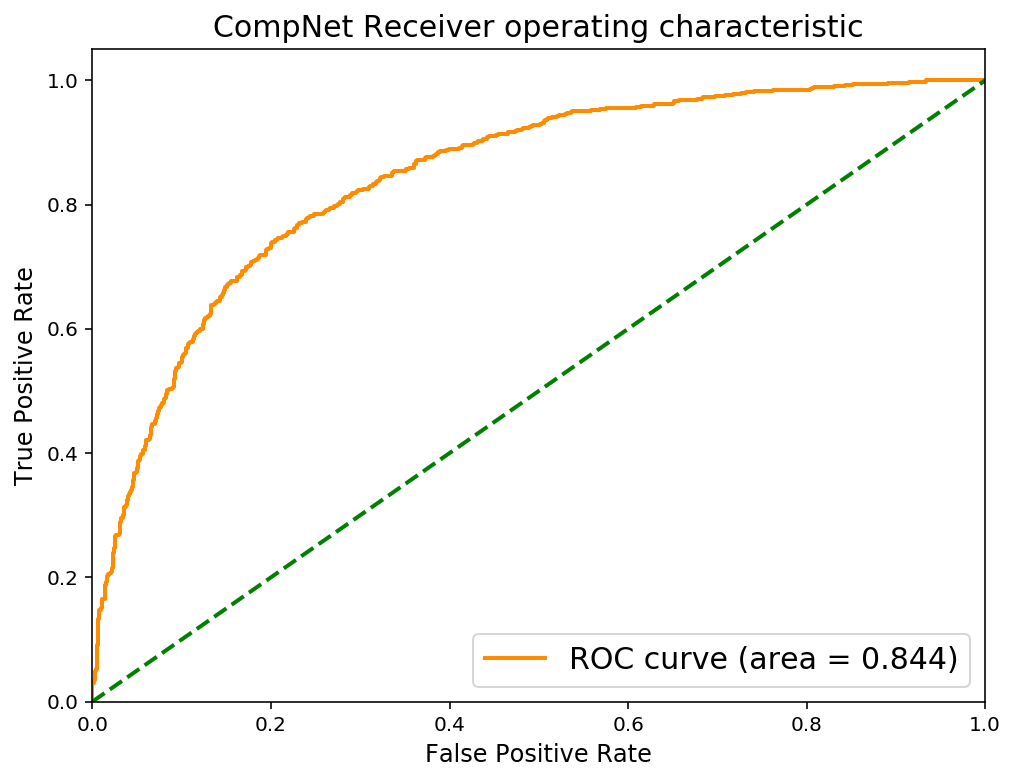

(21.981514930725098, 36.139751479029655, 775.0, 594.0, 133.0, 314.0, 57, 908)

In [37]:
eval_compnet(ensemble1, test_encoding_ds)

# Training out autodecoder and Ensemble CompNets on ModelNet40 data with 33 classes

In [ ]:
# Load the X_train, X_test, y_train, y_test after reading from the .npy file in the disk
train40 = "./data/ModelNet40_train_npy/"
test40 = "./data/ModelNet40_test_npy/"

# Warning: The train and test directories must have the same number of files
X_train40, y_train40 = get_X_y_from_npy(train40, 100)
X_test40, y_test40 = get_X_y_from_npy(test40, 100)

X_train40.shape, X_test40.shape, y_train40.shape, y_test40.shape

## Looking at ModelNet40 3D images

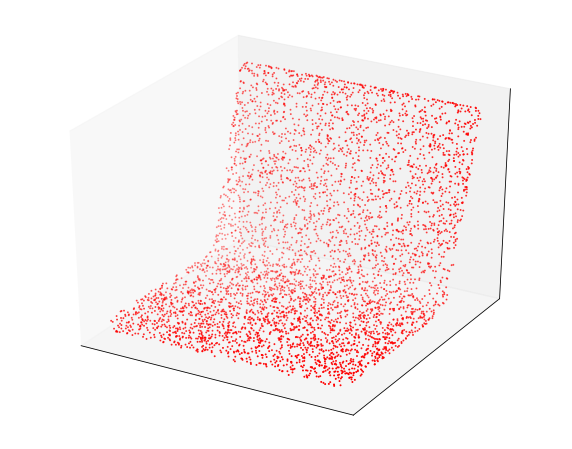

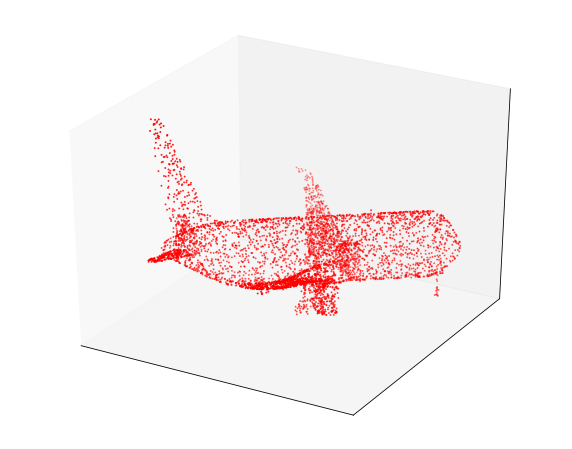

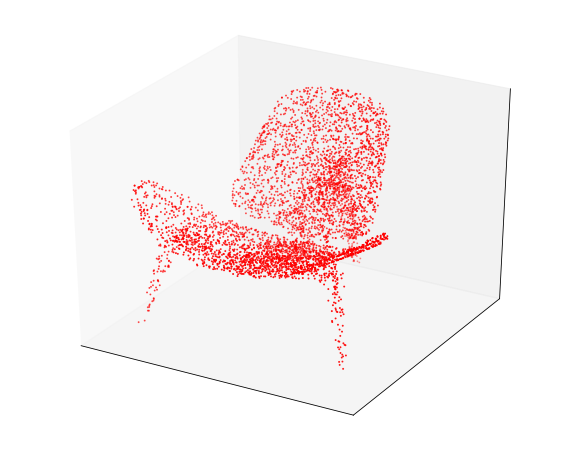

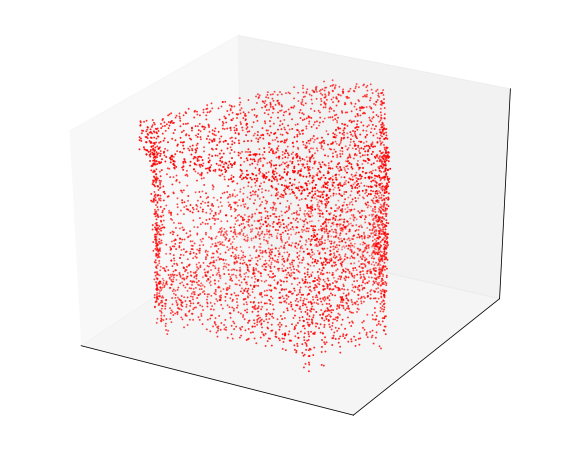

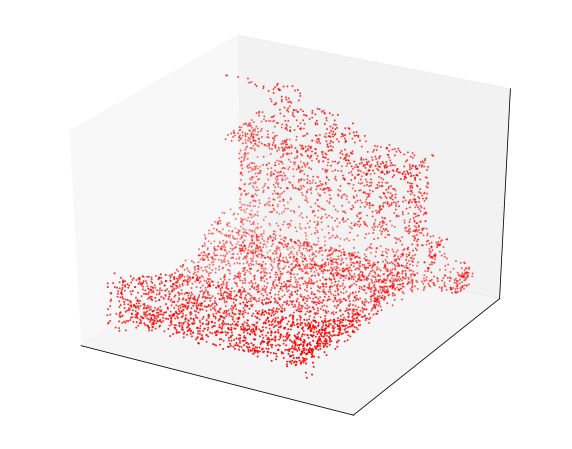

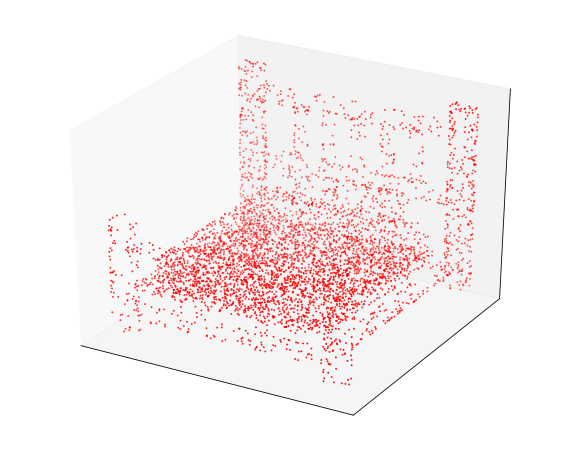

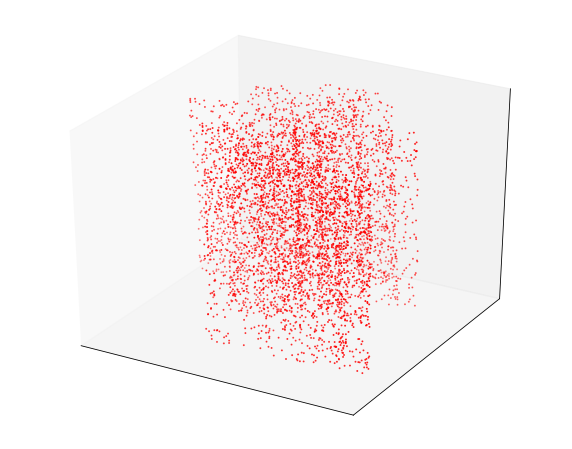

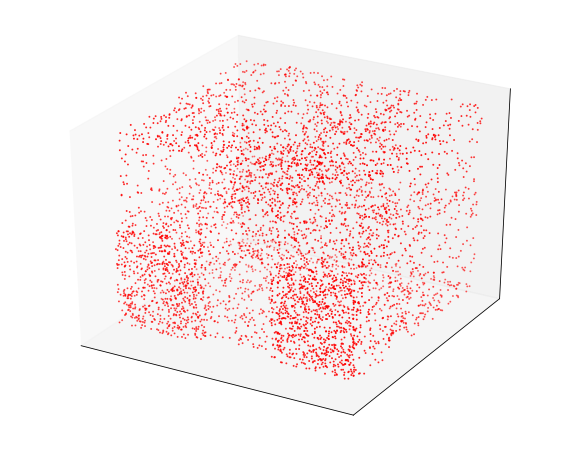

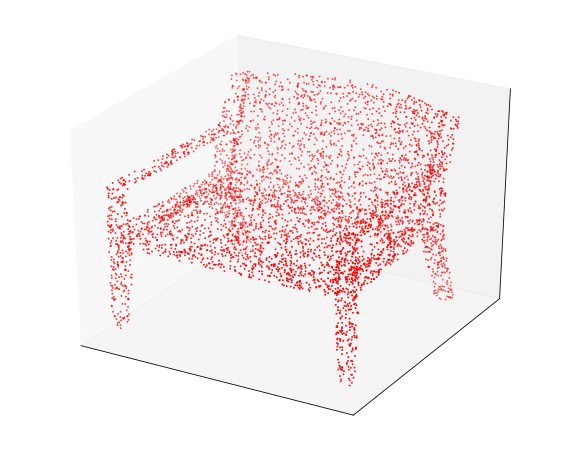

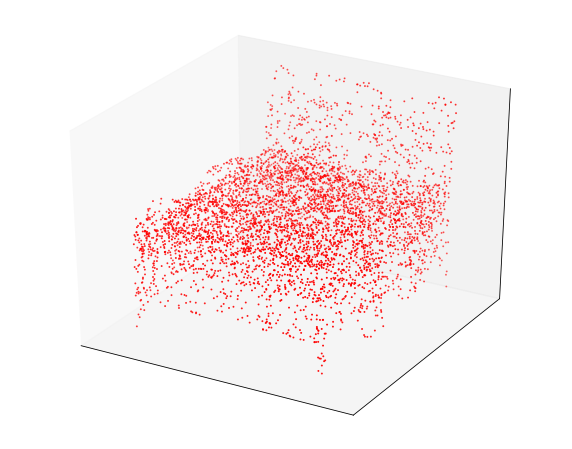

In [28]:
for i in range(10):
    visualize_npy(X_train40[i], save_img_fpath=f"./img/modelnet40_{i}.png")

## Training the autodecoder and generating the latent space encodings

In [ ]:
adnet_HP40 = HyperParameter(lr=0.001, epochs=4)
train_ds40 = PointDriftDS(X_train40, y_train40)
test_ds40 = PointDriftDS(X_test40, y_test40)

# train autodecoder
mn40_autodecoder = train_decoder(
    adnet_HP40, DS, train_ds=train_ds40, save_wt_fname="mnet40_decoder.pth"
)

# get the train encodings
train_encoding_ds40 = EncodingDS(PointDriftDS(X_train40, y_train40), mn40_autodecoder)
train_result40 = train_encoding_ds40.train_encodings(
    find_encoding, num_iterations=15, lr=0.05
)

# get the test encodings
test_encoding_ds40 = EncodingDS(PointDriftDS(X_test40, y_test40), mn40_autodecoder)
test_result40 = test_encoding_ds40.train_encodings(
    find_encoding, num_iterations=15, lr=0.05
)

## Train a single CompNet for classification on the ModelNet40 data

In [ ]:
# train the compnet
compnet_HP40 = HyperParameter(epochs=50, batch_size=16, lr=0.001)
mn40_compnet = train_compnet(
    compnet_HP40,
    DS,
    train_ds=train_encoding_ds40,
    save_wt_fname="mnet40_compnet.pth",
)

### Evaluate Single CompNet on ModelNet40 Data

In [44]:
eval_compnet(mn40_compnet, test_encoding_ds40)

------------------ Evaluation Report ------------------
Total Accuracy: 0.603225806451613
After 117 batches and 1860 test points

Metrics for the same class:
Avg loss: 0.8350983893769419
Precision: 0.6348314606741573
Recall: 0.4860215053763441
F1 Score: 0.5505481120584653

Metrics for the diff class:
Avg loss: 0.5771344566447103
Precision: 0.5836236933797909
Recall: 0.7204301075268817
F1 Score: 0.6448508180943214


(97.7065115571022, 67.5247314274311, 904.0, 1340.0, 956.0, 520.0, 117, 1860)

## Train Ensemble Compnet1 on ModelNet40 data

In [ ]:
ensemble_HP40 = HyperParameter(epochs=50, batch_size=16, lr=0.001)

# Train with the ensemble net
ensemble1_40 = train_compnet(
    ensemble_HP40,
    DS,
    train_ds=train_encoding_ds40,
    save_wt_fname="mnet40_ensemble1.pth",
    compnet=EnsembleCompNet(),
)

### Evaluate Ensemble CompNet1 on ModelNet40 Data

In [46]:
eval_compnet(ensemble1_40, test_encoding_ds40)

------------------ Evaluation Report ------------------
Total Accuracy: 0.7397849462365591
After 117 batches and 1860 test points

Metrics for the same class:
Avg loss: 0.44892520677202785
Precision: 0.7263959390862944
Recall: 0.7693548387096775
F1 Score: 0.7472584856396867

Metrics for the diff class:
Avg loss: 0.6485624200640581
Precision: 0.7548571428571429
Recall: 0.7102150537634409
F1 Score: 0.7318559556786703


(52.52424919232726, 75.8818031474948, 1431.0, 1321.0, 429.0, 539.0, 117, 1860)